# Réduction de dimensionnalité: visualisation & débruitage

## Organisation
* A. Visualisation de données (ACP)
    * A.1. Réduction de données 2D => 1D
    * A.2. Réduction de données nD => 2D
    * A.3. Interprétation des vecteurs propres
    * A.4. Vers un espace de représentation débruité 
* B. Projections non linéaires
    * B.1 TSNE
    * B.2 Et en dehors de TSNE? [OPT]
* C. Présenter ses résultats, enrichir ses modèles
    * C.1. Usage de la visualisation de données pour l'analyse des erreurs
    * C.2. Affichage interactif


In [1]:
# Importation des librairies standards:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle as pkl
import math
%matplotlib inline  


# A. Visualisation de données

Nous proposons une série d'expériences pour appréhender la visualisation de données et la réduction de la dimensionnalité:

1. Comprendre la signification des valeurs propres et vecteurs propres sur les données gaussiennes sur lesquelles nous avons travaillé jusqu'ici
1. Générer un jeu de données jouet en 3D puis réduire la dimensionnalité
1. Appliquer cette réduction de dimension sur les données USPS

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# données équilibrées (cas simple pour démarrer)
centers = [[-1,-1], [1,1]]
clusters_std = [1.,1.]
N = 100
X, Y = make_blobs(n_samples=N, centers=centers, cluster_std=clusters_std,  n_features=2,   random_state=0) # 100 pts, 2classes, 2dim 


plt.figure(facecolor='white')
plt.scatter(X[:,0],X[:,1],c=Y)

<span style="color:red"> EXO </span> Avant de lancer du code, répondez aux questions suivantes:
- Combien y a-t-il de vecteurs propres et de valeurs propres dans ce problème?
- Quel axe de plus forte variance est préssenti?


Vérifions maintenant avec du code.
L'idée est d'appliquer ```np.linalg.eig``` sur la matrice de correlation $X^T X$ et d'afficher les sorties pour les comprendre.

In [ ]:
# Récupération des valeurs propres et vecteurs propres & affichage:

# <CORRECTION>
lam,V = np.linalg.eig(X.T @ X) # travail sur la matrice des correlations pour extraire la plus grande variance
print(lam,"\n", V)

# </CORRECTION>

In [ ]:
# tracer les vecteurs propres, à partir de (0,0) sur le scatter des points
# A l'aide de la commande plt.text, vous pouvez rajouter la "force" des axes si vous voulez


# <CORRECTION>
plt.figure()
plt.scatter(X[:,0],X[:,1], c=Y)

plt.grid('on')
sc = 3
for i in range(len(V)):
    print(i)
    plt.plot([0,V[0,i]*sc], [0,V[1,i]*sc], 'r')
    plt.text(V[0,i]*sc,V[1,i]*sc,"{:.2f}".format(lam[i]), size=14)
    
plt.savefig("fig/acp.png",bbox_inches='tight',pad_inches=0)

#plt.legend(["cl1", "cl2","axe 1"+str(V[:,0]),"axe 2"+str(V[:,1])])

# </CORRECTION>

Check:
Vous devez obtenir

<img src="fig/acp.png">

On voit bien la principale direction de variance (associée à la plus grande valeur propre)

## A.1. Réduction de données 2D => 1D

Dans une logique de réduction de dimensionnalité, on souhaite:
1. extraire automatiquement le vecteur propre associé à la plus grande valeur propre
1. projeter les données sur cet axe
1. afficher le plot 1D des données suivant:
    - x = nouvelle coordonée (unique) du point
    - y = étiquette

Cet affichage va nous permettre de comprendre ce que nous venons de faire.

In [ ]:
# Projection sur le premier axe propre
# Afficher les points avec leur étiquette

# <CORRECTION>

# trouver l'axe principal:
ind = np.argmax(lam)
vp  = V[:,ind]

# figure etudiants

xp = X @ vp

plt.figure()
plt.plot(xp[Y==1], [1]*np.where(Y==1,1,0).sum(), '+')
plt.plot(xp[Y==0],[-1]*np.where(Y==0,1,0).sum(), '+')
plt.grid()

plt.savefig("fig/proj_1D.png",bbox_inches='tight', transparent=True,pad_inches=0)

# ======
# figure prof only
sc = 4
plt.figure(figsize=[5,5]) # eviter les déformation pour les projections soient orthogonales visuellement
plt.axis([-4, 4, -4, 4]) # pour eviter les déformations


plt.scatter(X[Y==1,0],X[Y==1,1])
plt.scatter(X[Y==0,0],X[Y==0,1])
plt.plot([-V[0,i]*sc,V[0,i]*sc], [-V[1,i]*sc,V[1,i]*sc], 'r', lw=2)
plt.grid()


theta = math.acos(vp[0] / (np.sqrt((vp**2).sum()))) * np.sign(math.asin(vp[1] / (np.sqrt((vp**2).sum()))))

print(theta*180/math.pi)

for x in X:
    plt.plot([x[0], (x@vp) * np.cos(theta)], [x[1], (x@vp) * np.sin(theta)], 'k',lw=0.5)

plt.savefig("fig/proj_2D.png",bbox_inches='tight', transparent=True,pad_inches=0)


# </CORRECTION>



Vous devez obtenir:

<table border="0">
 <tr>
    <td><img src="fig/proj_1D.png" width=300px></td>
    <td>L'axe de plus forte variance semble bien intéressant pour distinguer les deux classes de données</td>
 </tr>
</table>

Pour mieux comprendre ce qui se passe, je vous propose la figure explicative suivante qui illustre ce que vous avez fait du point de vue géométrique:
<img src="fig/proj_2D.png" width=300px>

**Note:** cette dernière figure est non-triviale à obtenir, il ne faut pas perdre du temps en TP à chercher comment faire :)

## A.2. Réduction de données d-D => 2D

Passons maintenant sur USPS pour essayer de reproduire les figures du cours

1. extraire automatiquement les 2 vecteurs propres associés aux 2 plus grandes valeurs propres sur les données USPS
1. projeter les données sur ces axes
    - projeter toutes les données
    - projeter seulement les 200 premières images (pour mieux voir)
1. afficher avec un code couleur correspondant aux classes

Cet affichage va nous permettre de comprendre ce que nous venons de faire.

In [20]:
# test sur les données USPS

data = pkl.load(open('data/usps.pkl', 'rb'))
Xu = np.array(data['X_train'], dtype=float) # conversion de type pour une meilleure compatibilité
Yu = np.array(data['Y_train'], dtype=float)
XTu = np.array(data['X_test'], dtype=float) # conversion de type pour une meilleure compatibilité
YTu = np.array(data['Y_test'], dtype=float)


Text(0.5, 1.0, 'label : 0.0')

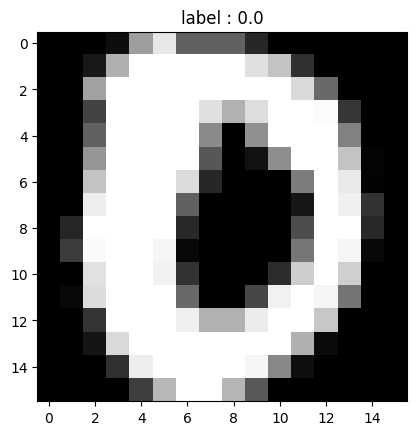

In [3]:
# recupération & affichage d'un échantillon
index = 0

plt.figure()
plt.imshow(Xu[index].reshape(16,16), cmap="gray")
# + affichage du titre + label
plt.title("label : "+str(Yu[index]))

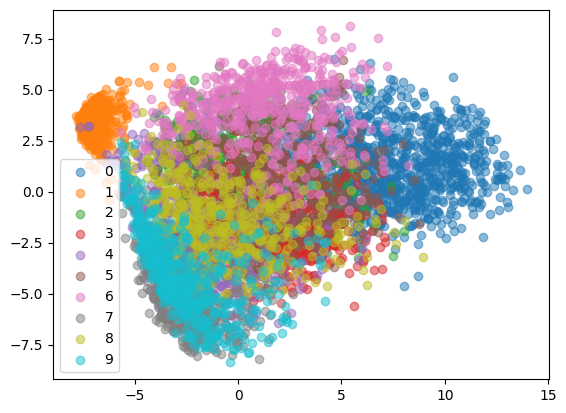

In [21]:

# calcul Valeur Propre / vecteur propre + tri & projection 2D

# pour la cohérence avec la suite:
# vp = stockage des vecteurs propres
from sklearn.preprocessing import StandardScaler

# Pour obtenir les mêmes résultats que sklearn => Centrage des données [les figures suivantes sont SANS le centrage]
Xuc = StandardScaler(with_std=False).fit_transform(Xu)

# <CORRECTION>
# Xu = Xu[:200]
# Yu = Yu[:200]
# 
lam,V = np.linalg.eig(Xuc.T @ Xuc) 

d = 4

ind = np.argsort(-lam)
vp  = V[:,ind[:d]]

Nlim = len(Yu)
xp = Xuc[:Nlim,:]@vp
yp = Yu[:Nlim]

plt.figure(facecolor='white')
for c in np.unique(Yu):
    plt.scatter(xp[yp==c,0], xp[yp==c,1], alpha=0.5)
plt.legend(np.arange(10))

# plt.savefig("fig/proj_usps_all.png",bbox_inches='tight',pad_inches=0) # , transparent=True

# </CORRECTION>

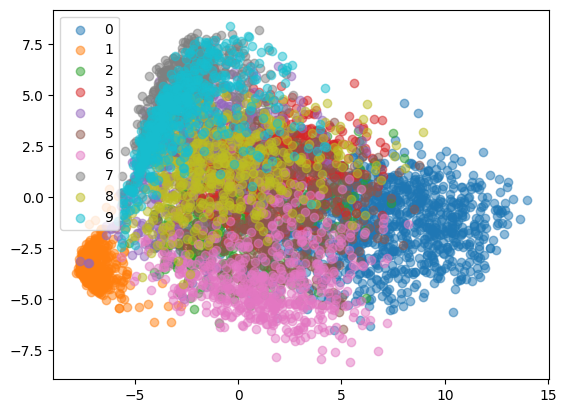

In [15]:
# meme chose avec l'objet PCA de sklearn
from sklearn.decomposition import PCA

# <CORRECTION>
pca = PCA(n_components=4)
xp2 = pca.fit_transform(Xu)



plt.figure(facecolor='white')
for c in np.unique(Yu):
    plt.scatter(xp2[Yu==c,0], xp2[Yu==c,1], alpha=0.5)
plt.legend(np.arange(10))

# </CORRECTION>

Vous devez obtenir:
<table border="0">
 <tr>
    <td><img src="./fig/proj_USPS_all.png"></td>
    <td><img src="./fig/proj_USPS_200.png"></td>
 </tr>
</table>

On a l'impression que les 0 et 1 sont bien séparés des autres classes... Le reste est un peu confus mais on voit que:
- les 8 et les 9 se ressemblent
- les 6 et les 3 dans une moindre mesure
- les 7 et les 4 un peu aussi
- les 2 sont en plein milieu



**Note : parmi les 1001 biais qui peuvent invalider votre analyse: l'ordre d'affichage des classes !!!**
- Les classes sont fortement superposées... L'inversion change-t-elle vos analyse?

In [ ]:
# refaire l'affichage précédent en inversant l'ordre de superposition

#<CORRECTION>
plt.figure(facecolor='white')
for c in np.unique(Yu)[::-1]: # petite astuce pour inverser un vecteur
    plt.scatter(xp[yp==c,0], xp[yp==c,1], alpha=0.5)
plt.legend(np.arange(10))

#</CORRECTION>

## A.3. Interprétation des vecteurs propres

Chacun de nos 2 axes contient beaucoup d'informations... Mais lesquelles?
Ces axes sont en 256 dimensions, il est possible de les tracer comme une image. Le truc est de distinguer les dimensions positives et les dimensions négatives.
On ne va pas reconstruire une échelle de couleur propre... Mais on peut a minima afficher l'échelle.

Le code est fourni.

<img src="./fig/usps_vp.png">
   

Le premier axe est sensible aux pixels allumés en haut et en bas: sur le premier axe de la figure de la boite précédente, on remarque que les chiffres les plus à droite sont le 0 et le 3... Ca colle.

Le second axe est sensible aux pixels à gauche et à droite (en positif) et aux pixels du centre (en négatif). On a bien les 0 en haut et les 1 en bas de ce second axe.

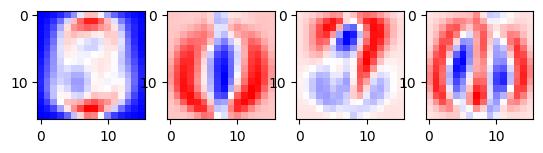

In [16]:
# choix du nombre de vecteur à afficher
nvec = 4

plt.figure(facecolor="white")

for i in range(nvec):
    plt.subplot(1, nvec,i+1)
    # il ne reste plus qu'à afficher le vecteur propre (1 ligne !)
    plt.imshow(vp[:,i].reshape(16,16),cmap='bwr')
# plt.colorbar()
# plt.savefig("fig/usps_vp.pdf",bbox_inches='tight', pad_inches=0)



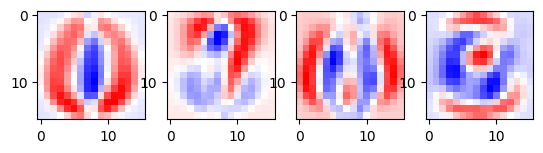

In [17]:
# V2 : les vecteurs de sklearn
# choix du nombre de vecteur à afficher
nvec = 4

plt.figure(facecolor="white")

for i in range(nvec):
    plt.subplot(1, nvec,i+1)
    # il ne reste plus qu'à afficher le vecteur propre (1 ligne !)
    plt.imshow(pca.components_[i].reshape(16,16),cmap='bwr')
# plt.colorbar()
# plt.savefig("fig/usps_vp.pdf",bbox_inches='tight', pad_inches=0)

## A.4. Vers un espace de représentation débruité [OPT]

Que se passe-t-il si on classe les points dans cet espace?
En 2d, on voit qu'il n'y a pas assez de dimension... Mais on peut:

1. Etudier les valeurs de toutes les valeurs propres (triées) pour voir combien sont importantes
    - soit on trie et on affiche les valeurs
    - soit on trace un histogramme des valeurs
1. Choisir un nombre de vecteurs propres par rapport à l'expérience précédente... On se rend compte que ce n'est pas évident: peu de valeur propre capte toute l'énergie. En tout état de cause, 20 valeurs propres semblent raisonnables
1. Projeter les données d'apprentissage et de test
1. Etudier le taux de bonne classification dans ce nouvel espace par rapport à l'espace d'origine

In [ ]:
# Etude des valeurs propres
lam,V = np.linalg.eig(Xu.T @ Xu) # réponse à la question précédente

plt.figure()
#plt.hist(lam, 40)
plt.plot(lam)
plt.savefig("valP.pdf",bbox_inches='tight', transparent=True,pad_inches=0)

In [ ]:
# réduction à 20 dimensions
ndim = 20
Xr = Xu @ V[:,:ndim]
XTr = XTu @ V[:,:ndim]

In [ ]:
# Apprentissage d'un perceptron multiclasse

from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

cl = Perceptron()
cl.fit(Xr, Yu)

ypred_A = cl.predict(Xr)
ypred_T = cl.predict(XTr)

perf_A = accuracy_score(ypred_A, Yu)
perf_T = accuracy_score(ypred_T, YTu)

print("Perf : ",perf_A, perf_T)

In [ ]:
# Evolution des performances en fonction du nombre de vecteurs propres retenus
perf = []
dims = np.concatenate((np.arange(2,16,2) , np.arange(20,100, 10), np.arange(120,250,20)))


for ndim in dims:
    Xr = Xu @ V[:,:ndim]
    XTr = XTu @ V[:,:ndim]
    cl = Perceptron()
    cl.fit(Xr, Yu)

    ypred_A = cl.predict(Xr)
    ypred_T = cl.predict(XTr)

    perf_A = accuracy_score(ypred_A, Yu)
    perf_T = accuracy_score(ypred_T, YTu)

    # print(ndim, "Perf : ",perf_A, perf_T)
    perf.append(perf_T)
    if ndim % 10 == 0: print(ndim)
plt.figure()
plt.plot(dims, perf)
plt.grid()

# B. Projections non linéaires

Les projections linéaires sont utilisées depuis très longtemps... Les projections non-linéaires sont plus récentes mais se développent très rapidement. Une des plus connue est TSNE, qui permet de visualiser les données en conservant les proximités locales (sans tenir compte des distances plus importantes).

## B.1. TSNE

Attention, dans le cas de TSNE, il s'agit d'une méthode (principalement) transductive: on projete (+affiche) un ensemble mais pas forcément des points supplémentaires ensuite.

In [ ]:
from sklearn.manifold import TSNE
# première expériences avec 200 points pour aller vite

N = 200
Xur = Xu[:N]
Yur = Yu[:N]

visu = TSNE() # paramètres par défaut
x2d = visu.fit_transform(Xur)

plt.figure(facecolor="white")
for y in np.unique(Yur):
    plt.scatter(x2d[Yur==y,0], x2d[Yur==y,1], alpha=0.5)
plt.legend(np.arange(10))

# plt.savefig("fig/tsne-200.png", bbox_inches='tight', pad_inches=0)

Résultat attendu (à l'initialisation aléatoire près):

<img src="fig/tsne-200.png">

<span style="color:orange"> L'interprétation du graphique précédent demande de la **prudence**: </span>
- il s'agit d'une projection en 2D: **beaucoup d'information ont été perdues**
- il s'agit **d'informations locales**: deux points éloignés sont arbitrairement loin. La classe 0 est loin de 1 et de 2 sans qu'on puisse tirer de conclusion sur une relation d'ordre.
- l'initialisation est aléatoire: les résultats varient d'une exécution à l'autre (les lointains s'échangent, la formulation est invariante en rotation, etc...). $\Rightarrow$ faire tourner plusieurs fois avant de tirer des conclusions
- la méthode, bien que très optimisée, reste un peu couteuse et ne permet souvent pas de *voir* toutes les données



On peut néanmoins tirer quelques conclusions:
- les classes 0 et 1 semblent assez faciles
- la classe 2 est isolées... Sauf certains points!
- la classe 6 est assez proche de 2 mais isolée quand même
- les classes 4 et 9 sont franchement mélangées
- la classe 8 semble présenter des échantillons durs (éparpillés dans les autres classes)

## B.2 Et en dehors de TSNE? [OPT]

Les algorithmes de projection en 2D sont nombreux: TSNE est l'arbre qui cache la forêt:
https://scikit-learn.org/stable/modules/manifold.html

Ca vaut le coup de tester MDS et ISOMAP.

UMAP préserve aussi la topologie globale des données (une sorte de compromis entre ACP et TSNE). Une belle démo est disponible ici:
https://pair-code.github.io/understanding-umap/




In [ ]:
# pour umap, il faut l'installer:
#!pip install umap-learn


In [ ]:
import umap
# première expériences avec 200 points pour aller vite

N = 500
Xur = Xu[:N]
Yur = Yu[:N]

mod = umap.UMAP()
emb = mod.fit_transform(Xur)
print(emb.shape)


In [ ]:

plt.figure(facecolor="white")
for y in np.unique(Yur):
    plt.scatter(emb[Yur==y,0], emb[Yur==y,1], alpha=0.5)
plt.legend(np.arange(10))


In [ ]:
# si vous voulez en tester un ou deux !



# C. Présenter ses résultats, enrichir ses modèles

## C.1. Usage de la visualisation de données pour l'analyse des erreurs

1. Construire un classifieur (linéaire) sur USPS
1. Afficher les données de test en 2D avec TSNE (sous-ensemble de taille 600)
1. Afficher les erreurs et tenter de construire des nouvelles hypothèses


In [ ]:
# 1. Construction du classifieur
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE

mod = LogisticRegression()
mod.fit(Xu,Yu)

# 2. Prediction + affichage
# <CORRECTION>
yhat = mod.predict(XTu)

visu = TSNE() # paramètres par défaut
x2d = visu.fit_transform(XTu)

N=500
x2dr = x2d[:N]
yr   = YTu[:N]
yhatr= yhat[:N]

plt.figure(facecolor="white")
for y in np.unique(yr):
    plt.scatter(x2dr[y==yr,0], x2dr[y==yr,1], alpha=0.5)
plt.legend(np.arange(10))
# </CORRECTION>

# 3. Affichage des points en 2D + erreurs sur les 500 premiers

# <CORRECTION>


ierr = yr != yhatr
plt.plot(x2dr[ierr,0], x2dr[ierr,1], "sk")

plt.savefig("fig/erreur.pdf", bbox_inches='tight')
# </CORRECTION>




## C.2. Affichage interactif, évolution dans les algorithmes

L'idée suivante est de construire un affichage qui permette d'explorer les données pour comprendre les difficultés spécifiques et les points abbérants.
Il faut donc un outils permettant de faire des scatter plot... En introduisant la possibilité de cliquer sur les points ou d'afficher des informations lors du survol des points avec la souris.

Plusieurs outils existent, l'un des plus connu est `bokeh`.

Les boites suivantes contiennent 2 exemples:
1. un simple scatter plot avec la possibilité de zoomer + la présentation des indices de points lors du passage de la souris
2. Un exemple plus avancé avec du `callback`: une fonction qui s'active lorsque l'utilisateur déclanche un évènement comme un clic.

L'idée était d'afficher directement l'image du point considéré... Mais l'interpréteur web de Visual Studio Code est un peu retourd et il y a des bugs... Tentez de le faire marcher et poser vos questions si vous ne comprennez pas!


In [ ]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.transform import linear_cmap
from bokeh.palettes import Spectral8
from bokeh.models import HoverTool


output_notebook()
ind = np.arange(len(x2d))
data = {'x': x2d[:,0], 'y': x2d[:,1], 'L': Yur, 'index': ind}
source = ColumnDataSource(data=data)
color_mapper = linear_cmap(field_name='L', palette=Spectral8, low=min(data['L']), high=max(data['L']))

p = figure(plot_width=600, plot_height=400)
p.circle('x', 'y', source=source, size=10, fill_color=color_mapper,legend_field='L')

hover = HoverTool(tooltips=[("Classe", "@L"),("Index","@index")])
p.add_tools(hover)

show(p)


In [ ]:
# sauvegarde des images pour la version 2 de l'interface
# 1. Créer les images + les sauver dasn un repertoire tmp
# 2. Les afficher lorsque qu'on clique

# attention assez long: on crée + sauvegarde plein d'images

import os
if not os.path.isdir('tmpfig'):
    os.mkdir('tmpfig')
for i,x in enumerate(Xur):
    plt.imshow(x.reshape(16,16), cmap="gray")
    plt.savefig('tmpfig/image_'+str(i)+'.png')

In [ ]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, CustomJS
from bokeh.layouts import column, row
from bokeh.transform import linear_cmap
from bokeh.palettes import Spectral8
from bokeh.models import HoverTool, TapTool
from bokeh.models.widgets import Div


output_notebook()
ind = np.arange(len(x2d))
data = {'x': x2d[:,0], 'y': x2d[:,1], 'L': Yur, 'index': ind}
source = ColumnDataSource(data=data)
color_mapper = linear_cmap(field_name='L', palette=Spectral8, low=min(data['L']), high=max(data['L']))

p = figure(plot_width=600, plot_height=400)
p.circle('x', 'y', source=source, size=10, fill_color=color_mapper,legend_field='L')

hover = HoverTool(tooltips=[("L", "@L")])
p.add_tools(hover)

# javascript => Afficher les éléments lors du clic (ou un lien vers les éléments)
code = """
    var index = source.data['index'][source.selected.indices[0]];
    //div.text = '<img src="./tmpfig/image_'+index+'.png">'; // tentative pour afficher l'image
    div.text = '<a href="./tmpfig/image_'+index+'.png"> lien vers image '+index+' <a>'; // '+index+'
"""

div = Div(text="Cliquez sur un point pour afficher l'indice.")
callback = CustomJS(args={'div': div,'source': source}, code=code)
tap = TapTool(callback=callback)
p.add_tools(tap)

layout = row(p, div)

show(layout)


## Exploitation de l'interface

Avez-vous réussi à identifier des points abbérants?

Avez-vous des pistes pour construire un classifieurs plus efficace?